# Mask2Face
This notebook will guide you through all the steps described in this article to build and train your ML model for removing the face mask of the person's face.

In [16]:
# Clone mask2face and enter the mask2face folder
%cd C:\Users\daryl\Development\imagine-ai\strv-ml-mask2face
# Install other depencencies
# fix albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible
!pip install imgaug==0.2.6
!pip install mtcnn
!pip install matplotlib
!pip install tqdm
!pip install cmake
!pip install sklearn
!pip install ipywidgets
#!conda install -c conda-forge dlib
#!pip install https://pypi.python.org/packages/da/06/bd3e241c4eb0a662914b3b4875fc52dd176a9db0d4a2c915ac2ad8800e9e/dlib-19.7.0-cp36-cp36m-win_amd64.whl#md5=b7330a5b2d46420343fbed5df69e6a3f
!pip install -r requirements.txt
print('end of installs')

C:\Users\daryl\Development\imagine-ai\strv-ml-mask2face
end of installs


In [17]:
# Necessary imports
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import download_data
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.architectures import UNet
from utils.model import Mask2FaceModel

In [18]:
tf.__version__

'2.7.0'

In [19]:
# setup HW

# is GPU available
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


In [20]:
# ##uncomment if you want to double check you are using the GPU
# tf.debugging.set_log_device_placement(True)

# # Create some tensors
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# print(c)

In [21]:
!nvidia-smi

Sun Dec 12 23:09:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P0    24W /  N/A |   7551MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1) Preconditions
First we need a dataset of human faces.

In [47]:
# Check if dataset is already downloaded or needs to be downloaded.
configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if os.path.isdir(dataset_path):
    print('Dataset already downloaded')
else:
    print('Downloading dataset')
    !mkdir 'data'
    dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
    download_data(configuration.get('dataset_archive_download_url'), dataset_archive_path)
    print('Extracting dataset')
    tar = tarfile.open(dataset_archive_path, 'r:gz')
    tar.extractall('data')
    tar.close()
    print('Done')

Dataset already downloaded


## 2) Data generation
Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

Testing and training data already generated
Here are few examples of generated data.


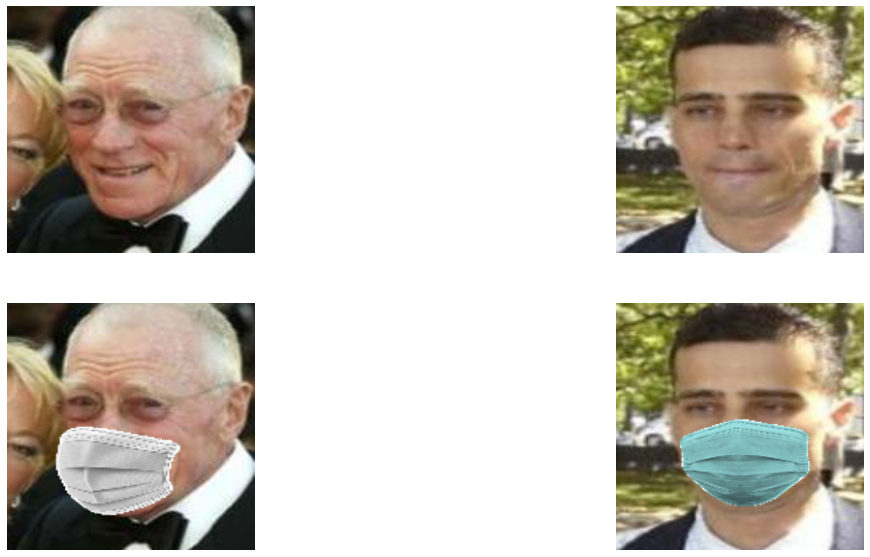

In [48]:
# setup the pipeline and generate data

dg = DataGenerator(configuration)

train_folder = configuration.get('train_data_path')
test_folder = configuration.get('test_data_path')

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print('Testing and training data already generated')
else:
    dg.generate_images()

print('Here are few examples of generated data.')
n_examples = 2
inputs, outputs = dg.get_dataset_examples(n_examples)
f, axarr = plt.subplots(2, n_examples, figsize=(20, 10))
for i in range(len(inputs)):
    axarr[1, i].imshow(mpimg.imread(inputs[i]))
    axarr[1, i].axis('off')
    axarr[0, i].imshow(mpimg.imread(outputs[i]))
    axarr[0, i].axis('off')

## 3) Model training
Now we have all the data, and we can initiate model and start training.

In [51]:
# Feel free to experiment with the number of filters, their sizes or any other parameters
filters = (64, 128, 128, 256, 256, 512)
kernels = (7, 7, 7, 3, 3, 3)
input_image_size = (256, 256, 3)
architecture = UNet.RESNET
training_epochs = 60
batch_size = 9
#stable settings on colab:
#reduced config data to 2000 train, 200 test due to cpu RAM OOM (not VRAM)
#train 2000
#test 200
#batch size 30
#epochs 15, colab forcefully ends it well before 20 are reached

#stable settings on local:
#reduced config data to 2000 train, 200 test due to cpu RAM OOM (not VRAM)
#train 10000
#test 1000
#batch size 9
#epochs 60 (stops after 37)


In [52]:
#uncomment to train own model
# Create instance of model and start training
model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                   kernels=kernels, configuration=configuration)
model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

# #If you already have pretrained model you can uncomment next line and load it instead of training new one
# model = Mask2FaceModel.load_model('models/model_epochs-20_batch-30_loss-ssim_l1_loss_20211211_21_17_48.h5') 

Using UNet Resnet model
Loading training data from data/train with limit of 10000 images
Loading testing data from data/test with limit of 1000 images
12/12 [==============================] - 13s 194ms/step - loss: 0.6512 - acc: 0.2300 - recall_7: 0.3831 - precision_7: 0.9842s - loss: 0.6460 - acc: 0.2261 - recall_7: 0.3833 - precision_7
- TEST -> LOSS:     0.6512, ACC:     0.2300, RECALL:     0.3831, PRECISION:     0.9842
Epoch 1/60
889/889 [==============================] - 958s 1s/step - loss: 0.1545 - acc: 0.8389 - recall_7: 0.4160 - precision_7: 1.0000 - val_loss: 0.1001 - val_acc: 0.9036 - val_recall_7: 0.3908 - val_precision_7: 1.0000
Epoch 2/60
889/889 [==============================] - 928s 1s/step - loss: 0.0812 - acc: 0.8956 - recall_7: 0.3650 - precision_7: 1.0000 - val_loss: 0.0787 - val_acc: 0.9109 - val_recall_7: 0.3560 - val_precision_7: 1.0000
Epoch 3/60
889/889 [==============================] - 928s 1s/step - loss: 0.0703 - acc: 0.9040 - recall_7: 0.3654 - precision_

## 4) Results
Our model is trained, and we can look at it's performance

No keypoints detected on image
(256, 256)
(247, 256)
(256, 256)
Outputs generated on previously unseen data.


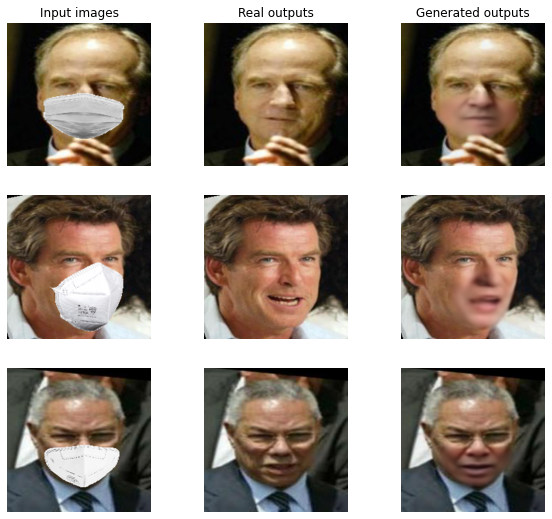

In [55]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 3
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=True)
f, axarr = plt.subplots(n_examples, 3, figsize=(10, n_examples * 3))
for i, img in enumerate(input_imgs):
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(input_imgs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(true_output_imgs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')
print('Outputs generated on previously unseen data.')

In [54]:
print('total runtime: '+str(37*925/3600))

total runtime: 9.506944444444445
